### Advanced Machine Learning Technologies. Autumn 2022.
### TASK 3. Sorokin Mikhail group J42322c.

In [145]:
import numpy as np
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(1234)

In [146]:
# Let's pick fashion_mnist dataset
train, test = tf.keras.datasets.fashion_mnist.load_data()

X_train, y_train = train
X_test, y_test = test
X_train = X_train / 255
X_test = X_test / 255

In [147]:
X_train.shape

(60000, 28, 28)

In [148]:
y_train.shape

(60000,)

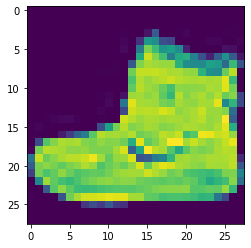

In [149]:
plt.imshow(X_train[0])

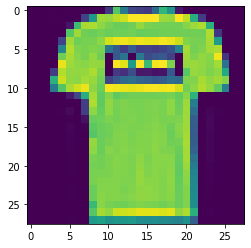

In [150]:
plt.imshow(X_train[1])

In [151]:
params = {
    'encoder_layers': [256],
    'decoder_layers': [256],
    'picture_classification_layers': [256],   # for conditions
    'activation': tf.nn.sigmoid,
    'decoder_std': 0.5,                     # std for P(x|z)
    'z_dim': 10,                            # latent space dimension
    'picture_classification_weight': 10.0,    # for conditions
    'epochs': 25,
    'batch_size': 100,
    'learning_rate': 0.001,
}

In [152]:
# tf.layers does not exist anymore in Tensorflow v2. So we use tf.compat.v1.layers

def encoder(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.compat.v1.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.compat.v1.layers.dense(z,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(z, 784)
    return tf.nn.sigmoid(mu)


def picture_classification(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    logits = tf.compat.v1.layers.dense(x, 10)
    return logits

In [153]:
# Encoding into a latent space
images = tf.compat.v1.placeholder(tf.float32, [None, 784])
pictures1 = tf.compat.v1.placeholder(tf.int32, [None])
encoder_mu, encoder_var = encoder(images, params['encoder_layers'])
eps = tf.compat.v1.random_normal(shape=[tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# Classify the picture
pic_logits = picture_classification(images, params['picture_classification_layers'])
pic_prob = tf.nn.softmax(pic_logits)

decoded_images = decoder(tf.concat([z, pic_prob], axis=1), params['decoder_layers'])

C:\Users\sorok\AppData\Local\Temp\ipykernel_4232\1533195561.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(x,
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\sorok\AppData\Local\Temp\ipykernel_4232\1533195561.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mu = tf.compat.v1.layers.dense(x, params['z_dim'])
C:\Users\sorok\AppData\Local\Temp\ipykernel_4232\1533195561.py:9: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  var = 1e-5 + tf.exp(tf.compat.v1.layers.dense(x, params['z_

In [154]:
# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.compat.v1.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.compat.v1.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_picture_classification = params['picture_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=pictures1,
                                                   logits=pic_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_picture_classification

train_op = tf.compat.v1.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [155]:
# Training

samples = []
losses_auto_encode = []
losses_picture_classification = []
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        batch_1 = int(X_train.shape[0] / params['batch_size'])
        for i in range(batch_1):
            batch_images = X_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_images2 = y_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_images = np.reshape(batch_images, (params['batch_size'], 784))
            batch_images2 = np.reshape(batch_images2, (params['batch_size'],))
            sess.run(train_op, feed_dict={images: batch_images, pictures1: batch_images2})

        loss_autoenc, loss_classification = sess.run([loss_auto_encode, loss_picture_classification],
                                                                            {images: np.reshape(X_train, (X_train.shape[0], 784)),
                                                                            pictures1: np.reshape(y_train, (y_train.shape[0], )) })
        losses_auto_encode.append(loss_autoenc)
        losses_picture_classification.append(loss_classification)
        print("Loss:", loss_autoenc + loss_classification)

        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[10, 1])
        gen_samples = sess.run(decoded_images,feed_dict={z: sample_z, pic_prob: np.eye(10)})
        samples.append(gen_samples)

print("\nTraining completed!")

Epoch # -  0
Loss: 240.25513
Epoch # -  1
Loss: 232.03766
Epoch # -  2
Loss: 228.8232
Epoch # -  3
Loss: 226.52586
Epoch # -  4
Loss: 225.29903
Epoch # -  5
Loss: 224.34804
Epoch # -  6
Loss: 223.2156
Epoch # -  7
Loss: 222.20546
Epoch # -  8
Loss: 221.31589
Epoch # -  9
Loss: 220.65117
Epoch # -  10
Loss: 220.05817
Epoch # -  11
Loss: 219.473
Epoch # -  12
Loss: 219.09196
Epoch # -  13
Loss: 218.54622
Epoch # -  14
Loss: 218.49849
Epoch # -  15
Loss: 217.91554
Epoch # -  16
Loss: 217.79967
Epoch # -  17
Loss: 217.39023
Epoch # -  18
Loss: 217.00462
Epoch # -  19
Loss: 216.92525
Epoch # -  20
Loss: 216.67506
Epoch # -  21
Loss: 216.5231
Epoch # -  22
Loss: 216.47934
Epoch # -  23
Loss: 216.08887
Epoch # -  24
Loss: 215.99403

Training completed!


Text(0.5, 0, 'Epochs')

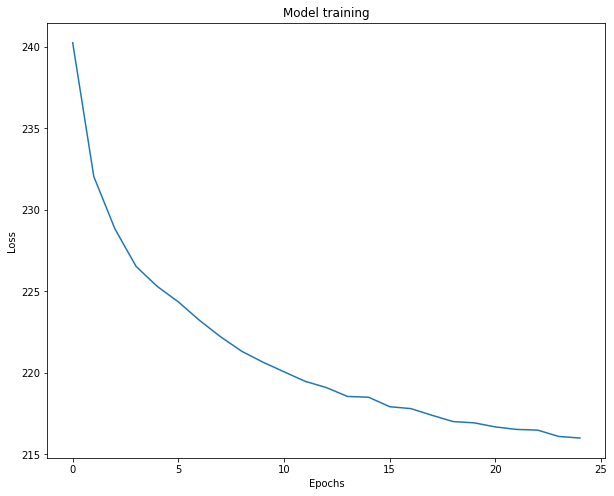

In [156]:
plt.figure(figsize=(10,8))
plt.plot(np.array(losses_auto_encode) + np.array(losses_picture_classification))
plt.title('Model training')
plt.ylabel('Loss')
plt.xlabel('Epochs')

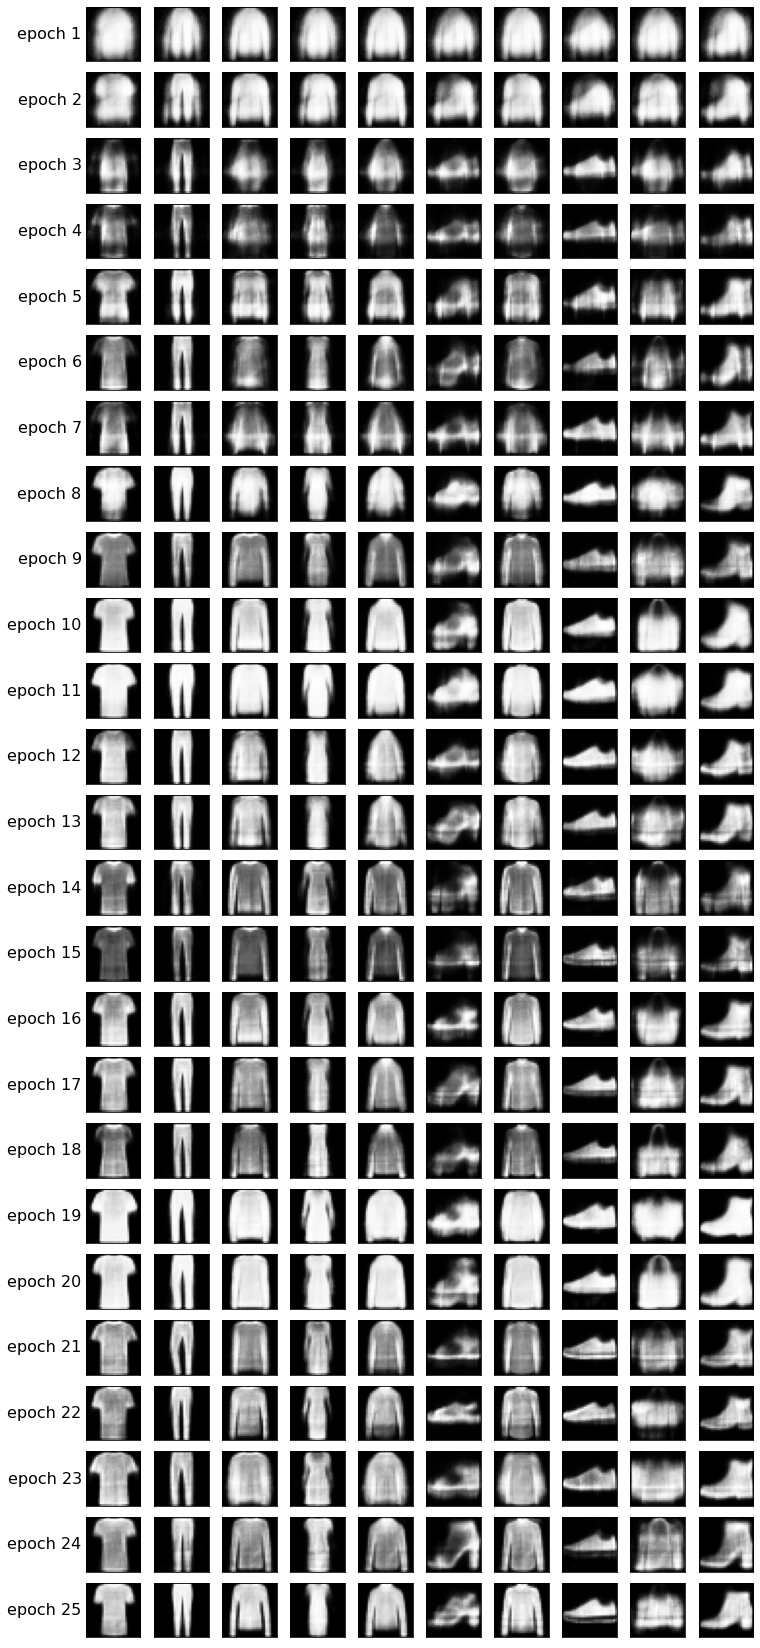

In [158]:
num_pictures = 10
def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(IMAGE_WIDTH * num_pictures,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_pictures,
                        epoch * num_pictures + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)

Epoch 24:


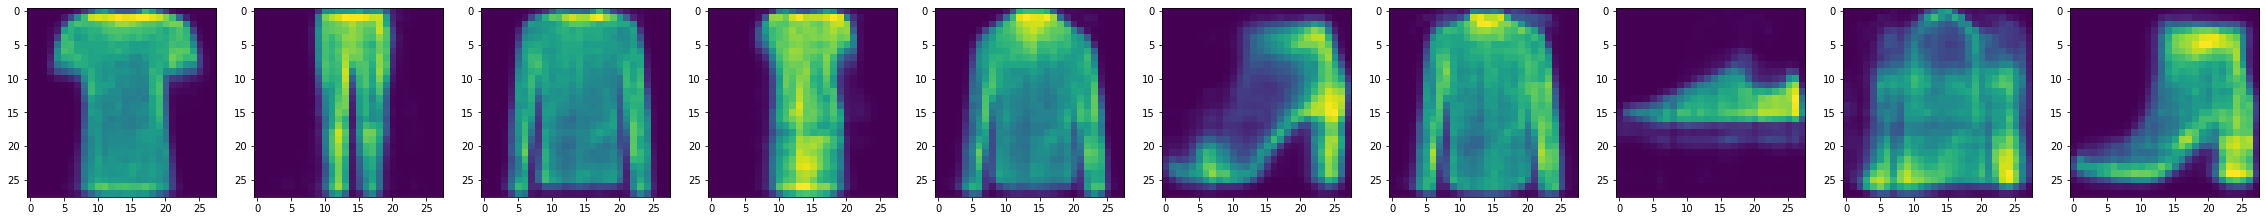

In [190]:
# I really liked the epoch 24 result, to me every clothes seems reasonable for that resolution
plt.figure(figsize=(40, 5))
for epoch, images in enumerate([samples[23]]):
    for pic, image in enumerate(images):
        plt.subplot(1, 10, pic + 1)
        plt.imshow(image.reshape((28, 28)))
print("Epoch 24:")